In [2]:
#from netCDF4 import Dataset  # http://code.google.com/p/netcdf4-python/
import os
import time
import datetime as dt
import xarray as xr
from datetime import datetime
import pandas
import matplotlib.pyplot as plt
import numpy as np
import math
####################you will need to change some paths here!#####################
#list of input directories
dir_storm_info='f:/data/tc_wakes/database/info/'
dir_out='f:/data/tc_wakes/database/sst/'
dir_flux = 'F:/data/model_data/oaflux/data_v3/daily/turbulence/'
dir_cmc = 'F:/data/sst/cmc/CMC0.2deg/v2/'
dir_ccmp='F:/data/sat_data/ccmp/v02.0/Y'
##where to get the data through opendap, use these directories instead
#dir_cmc = 'https://podaac-opendap.jpl.nasa.gov/opendap/allData/ghrsst/data/GDS2/L4/GLOB/CMC/CMC0.1deg/v3/'
#dir_flux = 'http://apdrc.soest.hawaii.edu:80/dods/public_data/WHOI_OAFlux/version3/daily/lh_oaflux/'
#the latest ccmp is from www.remss.com but they do not have an opendap server so you can use this instead:
#dir_ccmp='https://podaac-opendap.jpl.nasa.gov/opendap/allData/ccmp/L3.0/flk/'

#################################################################################
import geopy.distance
from math import sin, pi
from scipy import interpolate

#functions for running storm data
import sys
sys.path.append('C:/Users/gentemann/Google Drive/d_drive/python/storm_heat_content/subroutines/')
from storm_masking_routines import interpolate_storm_path
from storm_masking_routines import get_dist_grid
from storm_masking_routines import closest_dist
from storm_masking_routines import calculate_storm_mask



In [3]:

#plot output data and mask

import os
dir_out_figures = 'F:/data/tc_wakes/database/figs/check_storm_dist/'
iyr_storm,inum_storm = 2003,27
for inum_storm in range(1,58): #100):
    filename = dir_out + str(iyr_storm) + '/' + str(inum_storm).zfill(3) + '_interpolated_track.nc'
    exists = os.path.isfile(filename)
    if not exists:
        continue
    print(filename)
    ds_storm=xr.open_dataset(filename)
    ds_storm = ds_storm.sel(j2=0)
    ds_storm.close()
#    ds_storm['lon'] = (ds_storm.lon + 180) % 360 - 180
    filename = dir_out + str(iyr_storm) + '/' + str(inum_storm).zfill(3) + '_combined_data.nc'
    ds_all = xr.open_dataset(filename)
    ds_all.close()
    #ds_all = ds_all.sortby('lon')
    print(ds_all.lon[0].values,ds_all.lon[-1].values)
    if abs(ds_all.lon[-1]-ds_all.lon[0])>180:
        ds_all.coords['lon'] = np.mod(ds_all['lon'], 360)
        #ds_all = ds_all.sortby(ds_all.lon)
        ds_storm['lon'] = np.mod(ds_storm['lon'], 360)
        #ds_storm = ds_storm.sortby(ds_storm.lon)
    plt.figure(figsize=(15,3.5))
    plt.subplot(131)
    ds_all.side_of_storm.plot()
    plt.plot(ds_storm.lon,ds_storm.lat,'w')
    plt.plot(ds_storm.lon[0],ds_storm.lat[0],'w*')
    plt.subplot(132)
    ds_all.dist_from_storm_km.plot(vmin=0,vmax=3000)
    plt.plot(ds_storm.lon,ds_storm.lat,'w')
    max_lat = ds_storm.lat.max()
    if max_lat<0:
        cond = ((ds_all.dist_from_storm_km<100) & (ds_all.side_of_storm<=0)) |  ((ds_all.dist_from_storm_km<800) & (ds_all.side_of_storm>0))
    else:
        cond = ((ds_all.dist_from_storm_km<800) & (ds_all.side_of_storm<0)) |  ((ds_all.dist_from_storm_km<100) & (ds_all.side_of_storm>=0))
    subset = ds_all.where(cond)
    plt.subplot(133)
    subset.dist_from_storm_km.plot(vmin=0,vmax=3000)
    plt.plot(ds_storm.lon,ds_storm.lat,'w')
    filename = dir_out_figures + str(iyr_storm) + str(inum_storm).zfill(3) + '_interpolated_track.png'
    plt.savefig(filename,dpi=100,bbox_inches='tight')
    plt.close()

f:/data/tc_wakes/database/sst/2003/002_interpolated_track.nc
38.375 88.125
f:/data/tc_wakes/database/sst/2003/003_interpolated_track.nc
171.625 236.125
f:/data/tc_wakes/database/sst/2003/004_interpolated_track.nc
49.375 99.125
f:/data/tc_wakes/database/sst/2003/005_interpolated_track.nc
157.875 194.625
f:/data/tc_wakes/database/sst/2003/006_interpolated_track.nc
23.625 60.125
f:/data/tc_wakes/database/sst/2003/008_interpolated_track.nc
107.875 147.375
f:/data/tc_wakes/database/sst/2003/009_interpolated_track.nc
59.375 89.125
f:/data/tc_wakes/database/sst/2003/010_interpolated_track.nc
136.375 172.875
f:/data/tc_wakes/database/sst/2003/011_interpolated_track.nc
169.625 231.125
f:/data/tc_wakes/database/sst/2003/012_interpolated_track.nc
150.375 178.875
f:/data/tc_wakes/database/sst/2003/013_interpolated_track.nc
32.375 77.875
f:/data/tc_wakes/database/sst/2003/015_interpolated_track.nc
80.875 127.375
f:/data/tc_wakes/database/sst/2003/016_interpolated_track.nc
71.375 99.125
f:/data/tc_w

In [6]:

#start to look at data and make some pdfs

import os
dir_out_figures = 'F:/data/tc_wakes/database/figs/check_storm_dist/'
iyr_storm = 2003
#for inum_storm in range(1,58): #100):
inum_storm = 5
filename = dir_out + str(iyr_storm) + '/' + str(inum_storm).zfill(3) + '_interpolated_track.nc'
exists = os.path.isfile(filename)
#if not exists:
#    continue
print(filename)
ds_storm_info=xr.open_dataset(filename)
ds_storm_info = ds_storm_info.sel(j2=0)
ds_storm_info.close()
filename = dir_out + str(iyr_storm) + '/' + str(inum_storm).zfill(3) + '_combined_data.nc'
ds_all = xr.open_dataset(filename)
ds_all.close()
if abs(ds_all.lon[-1]-ds_all.lon[0])>180:
    ds_all.coords['lon'] = np.mod(ds_all['lon'], 360)
    ds_storm_info['lon'] = np.mod(ds_stor_infom['lon'], 360)
max_lat = ds_storm.lat.max()
if max_lat<0:
    cond = ((ds_all.dist_from_storm_km<100) & (ds_all.side_of_storm<=0)) |  ((ds_all.dist_from_storm_km<800) & (ds_all.side_of_storm>0))
else:
    cond = ((ds_all.dist_from_storm_km<800) & (ds_all.side_of_storm<0)) |  ((ds_all.dist_from_storm_km<100) & (ds_all.side_of_storm>=0))
subset = ds_all.where(cond)
#subset now only has the data within 100 and 800 km of storm

    

f:/data/tc_wakes/database/sst/2003/005_interpolated_track.nc


In [7]:
ds_storm_info

<xarray.Dataset>
Dimensions:  (i2: 72)
Dimensions without coordinates: i2
Data variables:
    lon      (i2) float64 ...
    lat      (i2) float64 ...
    time     (i2) float64 ...

In [17]:
filename = 'F:/data/tc_wakes/database/info/2003/006annual_storm_info.nc'
ds_storm_info = xr.open_dataset(filename)
lats = ds_storm_info.lat[0,:]
lons = ds_storm_info.lon[0,:]  #lons goes from 0 to 360
lons = (lons + 180) % 360 - 180 #put -180 to 180
dysince = ds_storm_info.time
ds_storm_info.close()
ds_storm_info

<xarray.Dataset>
Dimensions:  (i2: 61, j2: 1)
Dimensions without coordinates: i2, j2
Data variables:
    lon      (j2, i2) float64 ...
    lat      (j2, i2) float64 ...
    time     (j2, i2) float64 ...

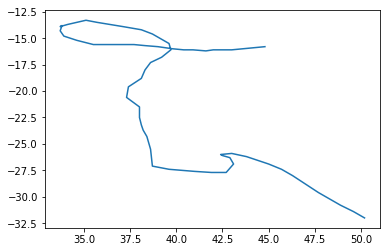

In [18]:
plt.plot(ds_storm_info.lon[0,:],ds_storm_info.lat[0,:])

In [13]:
lyr=2003
filename='F:/data/tc_wakes/ibtracks/year/Year.'+str(lyr)+'.ibtracs_wmo.v03r10.nc'
ds_storm_info = xr.open_dataset(filename)
ds_storm_info.close()
ds_storm_info

<xarray.Dataset>
Dimensions:          (center: 26, storm: 97, time: 137)
Dimensions without coordinates: center, storm, time
Data variables:
    storm_sn         (storm) |S13 ...
    name             (storm) |S57 ...
    numObs           (storm) int16 ...
    season           (storm) int16 ...
    track_type       (storm) int8 ...
    genesis_basin    (storm) int8 ...
    num_basins       (storm) int8 ...
    basin            (storm, time) float32 ...
    wind_avg_period  (center) float32 ...
    source           (center) |S10 ...
    time_wmo         (storm, time) datetime64[ns] ...
    lat_wmo          (storm, time) float32 ...
    lon_wmo          (storm, time) float32 ...
    alt              (storm, time) float32 ...
    wind_wmo         (storm, time) float32 ...
    pres_wmo         (storm, time) float32 ...
    sub_basin        (storm, time) float32 ...
    nature_wmo       (storm, time) float32 ...
    source_wmo       (storm, time) float32 ...
    dist2land        (storm, time

In [ ]:
#test storm
isave_mld_year = 0 #init MLD monthly data read flag
for root, dirs, files in os.walk(dir_storm_info, topdown=False):
    if root[len(dir_storm_info):len(dir_storm_info)+1]=='.':
        continue
    for name in files:
        if not name.endswith('.nc'):
            continue
        filename=os.path.join(root, name)
        print(filename[36:39],filename[31:35])
        inum_storm=int(filename[36:39])
        iyr_storm=int(filename[31:35])

        
        if iyr_storm!=2003:
            continue
        if inum_storm!=5:
            continue
#        if iyr_storm==2002 and inum_storm<9:
#            continue
        
        
#        if iyr_storm!=2007: # or iyr_storm<2003:
#            continue
        print(name,filename)
        ds_storm_info = xr.open_dataset(filename)
        lats = ds_storm_info.lat[0,:]
        lons = ds_storm_info.lon[0,:]  #lons goes from 0 to 360
        lons = (lons + 180) % 360 - 180 #put -180 to 180
        dysince = ds_storm_info.time
        ds_storm_info.close()
        
#make lat and lon of storm onto 25 km grid for below
        lons = (((lons - .125)/.25+1).astype(int)-1)*.25+.125
        lats = (((lats + 89.875)/.25+1).astype(int)-1)*.25-89.875
        
        iwrap=0
#calculate size of box to get data in
        minlon,maxlon = min(lons.values)-10, max(lons.values)+10
        minlat,maxlat = min(lats.values)-10, max(lats.values)+10

        ydim_storm = round((maxlat - minlat)/.25).astype(int)
        new_lat_storm = np.linspace(minlat, maxlat, ydim_storm)
        if (minlon<-90 and maxlon>=90) or (minlon<-180 and maxlon<0):  #this storm wraps  keep everythig 0 to 360 then wrap data at very end
            iwrap = 1
            lons2 = np.mod(lons, 360)
            minlon, maxlon = min(lons2.values)-10, max(lons2.values)+10
            xdim_storm = round((maxlon - minlon)/.25).astype(int)
            new_lon_storm = np.linspace(minlon, maxlon, xdim_storm)
        else:
            xdim_storm = round((maxlon - minlon)/.25).astype(int)
            new_lon_storm = np.linspace(minlon, maxlon, xdim_storm)

        print(iwrap,minlon,maxlon)
        print(iwrap,xdim_storm, new_lon_storm[:5],new_lon_storm[-5:])

        
        date_1858 = dt.datetime(1858,11,17,0,0,0) # start date is 11/17/1958
        dims=lats.shape
        tdim=dims[0]
        tem_date=[0]*tdim #print(dysince.values)
        for i in range(0,tdim):
            tem_date[i]=date_1858+dt.timedelta(days=float(dysince[0,i].values))  #create new time array that can be queried for year etc
        min_date = min(tem_date)+dt.timedelta(days=-5)
        max_date = max(tem_date)+dt.timedelta(days=5)
        minjdy = min_date.timetuple().tm_yday  #create new time array that can be queried for year etc
        minyear =min_date.year #create new time array that can be queried for year etc
        minmon =min_date.month #create new time array that can be queried for year etc
        minday =min_date.day #create new time array that can be queried for year etc
        maxjdy = max_date.timetuple().tm_yday  #create new time array that can be queried for year etc
        maxyear =max_date.year  #create new time array that can be queried for year etc
        print(minyear,minjdy,maxyear,maxjdy)
        
        dif = max(tem_date)-min(tem_date)
        tdim=int(dif.days)+30             #calculate ssts for 30 days after storm

        #print(tdim,xdim,ydim)            
        filename = dir_out + str(iyr_storm) + '/' + str(inum_storm).zfill(3) + '_combined_data.nc'
        ds_all = xr.open_dataset(filename,drop_variables=['uwnd','vwnd','dbss_obml','lhtfl','shtfl','tmp2m ','hum2m','analysed_sst_clim'])
        ds_all.close()
        
#        ds_all = xr.merge([ds_storm_ccmp, ds_storm_mld, ds_storm_lhf, ds_storm_shf, ds_storm_ta, ds_storm_qa, ds_storm_sst])
        if iwrap==1:
            ds_all.coords['lon'] = np.mod(ds_all['lon'], 360)
            ds_storm_info['lon'] = np.mod(ds_storm_info['lon'], 360)

        #calculate mask
        print('caluculating mask')
        ds_mask = calculate_storm_mask(ds_all,lats,lons)
        ds_all['storm_mask']=ds_mask['storm_mask']
        #dist to storm
        print('calculating dist')
        dist,index,stime,position,ds_storm_interp = closest_dist(ds_all,ds_storm_info)
        dtem=xr.DataArray(dist, coords={'lat': ds_mask.lat.values, 'lon':ds_mask.lon.values}, dims=('lat', 'lon'))
        ds_all['dist_from_storm_km']=dtem
        dtem=xr.DataArray(index, coords={'lat': ds_mask.lat.values, 'lon':ds_mask.lon.values}, dims=('lat', 'lon'))
        ds_all['closest_storm_index']=dtem
        dtem=xr.DataArray(stime, coords={'lat': ds_mask.lat.values, 'lon':ds_mask.lon.values}, dims=('lat', 'lon'))
        ds_all['closest_storm_time']=dtem
        dtem=xr.DataArray(position, coords={'lat': ds_mask.lat.values, 'lon':ds_mask.lon.values}, dims=('lat', 'lon'))
        ds_all['side_of_storm']=dtem

        
        filename = dir_out + str(iyr_storm) + '/' + str(inum_storm).zfill(3) + '_combined__masking_data.nc'
        ds_all.to_netcdf(filename)
        print('out:',filename)
        filename = dir_out + str(iyr_storm) + '/' + str(inum_storm).zfill(3) + '_interpolated_track.nc'
        ds_storm_interp.to_netcdf(filename)
        print('out:',filename)
    


In [ ]:
        filename = dir_out + str(iyr_storm) + '/' + str(inum_storm).zfill(3) + '_combined__masking_data2.nc'
        ds_all.to_netcdf(filename)
        print('out:',filename)
        filename = dir_out + str(iyr_storm) + '/' + str(inum_storm).zfill(3) + '_interpolated_track2.nc'
        ds_storm_interp.to_netcdf(filename)
        print('out:',filename)
